## Librerías

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

## Cargar datasets

In [22]:
def load_iris_data():
    """Carga y prepara el dataset iris.csv"""
    try:
        data = pd.read_csv('iris.csv', header=0)
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
        return X, y, list(y.unique())
    except FileNotFoundError:
        print("Error: 'iris.csv' no encontrado. Asegúrate de que esté en el mismo directorio.")
        return None, None, None
    except Exception as e:
        print(f"Error al leer 'iris.csv': {e}")
        return None, None, None

In [23]:
def load_emails_data():
    """Carga y prepara el dataset emails.csv"""
    try:
        data = pd.read_csv('emails.csv')
        X = data.iloc[:, 1:-1]
        y = data.iloc[:, -1]
        target_names = ['No Spam (0)', 'Spam (1)']
        return X, y, target_names
    except FileNotFoundError:
        print("Error: 'emails.csv' no encontrado. Asegúrate de que esté en el mismo directorio.")
        return None, None, None
    except Exception as e:
        print(f"Error al leer 'emails.csv': {e}")
        return None, None, None

## Procesar el dataset

In [24]:
def process_dataset(dataset_name, load_function):
    """Proceso completo para un dataset"""
    print(f"\n{'=' * 70}")
    print(f"Procesando Dataset: {dataset_name}")
    print(f"{'=' * 70}")
    
    X, y, target_names = load_function()
    if X is None:
        return (None, None), None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )

    print(f"\nDatos cargados correctamente:")
    print(f"   - Total de instancias: {X.shape[0]}")
    print(f"   - Entrenamiento (70%): {X_train.shape[0]}")
    print(f"   - Prueba (30%): {X_test.shape[0]}")

    # --- Etapa de Entrenamiento y Validación (para Tabla 1) ---
    print("\nEtapa 1: Validación Cruzada (k=3)")
    
    models = {
        '1-NN (uniforme)': KNeighborsClassifier(n_neighbors=1, weights='uniform'),
        '10-NN (uniforme)': KNeighborsClassifier(n_neighbors=10, weights='uniform'),
        '10-NN (distancia)': KNeighborsClassifier(n_neighbors=10, weights='distance')
    }
    kf = KFold(n_splits=3)
    
    cv_results = {}
    
    for model_name, model in models.items():
        fold_accuracies = []
        print(f"\nEvaluando modelo: {model_name}")
        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), start=1):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred_val = model.predict(X_val_fold)
            acc = accuracy_score(y_val_fold, y_pred_val)
            fold_accuracies.append(acc)
            print(f"   • Pliegue {fold}: Accuracy = {acc:.4f}")
        
        avg_acc = np.mean(fold_accuracies)
        print(f"   → Promedio de accuracy ({model_name}): {avg_acc:.4f}")
        
        cv_results[model_name] = {
            '1': fold_accuracies[0],
            '2': fold_accuracies[1],
            '3': fold_accuracies[2],
            'Promedio': avg_acc
        }

    # --- Etapa de Pruebas (para Tabla 2 y Reportes) ---
    print("\nEtapa 2: Pruebas Finales")
    
    best_model_name = max(cv_results, key=lambda k: cv_results[k]['Promedio'])
    print(f"\nMejor modelo seleccionado: {best_model_name} (según promedio de validación)")

    # Reconstruir el mejor modelo
    if '1-NN' in best_model_name:
        best_model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
        vecinos = 1
        pesos = '-'
    elif 'uniforme' in best_model_name:
        best_model = KNeighborsClassifier(n_neighbors=10, weights='uniform')
        vecinos = 10
        pesos = 'uniforme'
    else:
        best_model = KNeighborsClassifier(n_neighbors=10, weights='distance')
        vecinos = 10
        pesos = 'distancia'
    
    best_model.fit(X_train, y_train)
    
    y_pred_test = best_model.predict(X_test)
    final_accuracy = accuracy_score(y_test, y_pred_test)
    
    final_test_result = {
        'Dataset': dataset_name,
        'Vecinos': vecinos,
        'Pesos': pesos,
        'Accuracy': final_accuracy
    }

    print(f"\nAccuracy final en conjunto de prueba: {final_accuracy:.4f}")
    print(f"\nReporte de Clasificación Final ({dataset_name} - {best_model_name}):")
    print("=" * 70)
    print(classification_report(y_test, y_pred_test, target_names=target_names))
    
    print(f"\nMatriz de Confusión ({dataset_name} - {best_model_name}):")
    print("-" * 70)
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)
    
    try:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Matriz de Confusión - {dataset_name} ({best_model_name})')
        plt.show()
    except Exception as e:
        print(f"Advertencia: No se pudo mostrar la matriz de confusión gráfica. {e}")

    print(f"{'-' * 70}")
    
    return cv_results, final_test_result

In [25]:
tabla_1_data = {}
tabla_2_data = []

### Procesar Iris


Procesando Dataset: iris.csv

Datos cargados correctamente:
   - Total de instancias: 150
   - Entrenamiento (70%): 105
   - Prueba (30%): 45

Etapa 1: Validación Cruzada (k=3)

Evaluando modelo: 1-NN (uniforme)
   • Pliegue 1: Accuracy = 0.8571
   • Pliegue 2: Accuracy = 1.0000
   • Pliegue 3: Accuracy = 0.9429
   → Promedio de accuracy (1-NN (uniforme)): 0.9333

Evaluando modelo: 10-NN (uniforme)
   • Pliegue 1: Accuracy = 0.9143
   • Pliegue 2: Accuracy = 1.0000
   • Pliegue 3: Accuracy = 0.9143
   → Promedio de accuracy (10-NN (uniforme)): 0.9429

Evaluando modelo: 10-NN (distancia)
   • Pliegue 1: Accuracy = 0.9143
   • Pliegue 2: Accuracy = 1.0000
   • Pliegue 3: Accuracy = 0.9143
   → Promedio de accuracy (10-NN (distancia)): 0.9429

Etapa 2: Pruebas Finales

Mejor modelo seleccionado: 10-NN (uniforme) (según promedio de validación)

Accuracy final en conjunto de prueba: 0.9778

Reporte de Clasificación Final (iris.csv - 10-NN (uniforme)):
                 precision    recall  

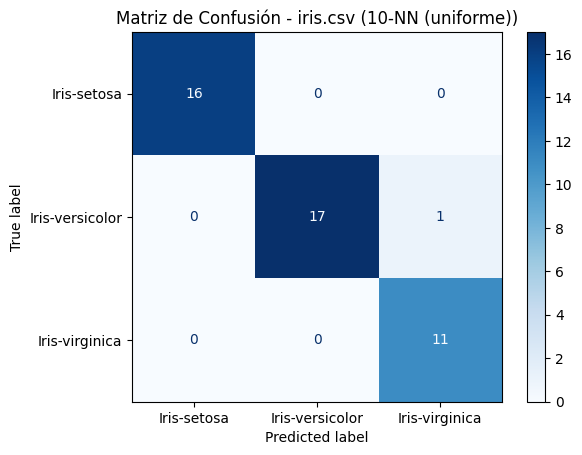

----------------------------------------------------------------------


In [26]:
cv_iris, test_iris = process_dataset('iris.csv', load_iris_data)
if cv_iris:
    tabla_1_data['iris.csv'] = cv_iris
if test_iris:
    tabla_2_data.append(test_iris)

### Procesar Emails


Procesando Dataset: emails.csv

Datos cargados correctamente:
   - Total de instancias: 5172
   - Entrenamiento (70%): 3620
   - Prueba (30%): 1552

Etapa 1: Validación Cruzada (k=3)

Evaluando modelo: 1-NN (uniforme)
   • Pliegue 1: Accuracy = 0.8567
   • Pliegue 2: Accuracy = 0.8360
   • Pliegue 3: Accuracy = 0.8466
   → Promedio de accuracy (1-NN (uniforme)): 0.8464

Evaluando modelo: 10-NN (uniforme)
   • Pliegue 1: Accuracy = 0.8757
   • Pliegue 2: Accuracy = 0.8476
   • Pliegue 3: Accuracy = 0.8599
   → Promedio de accuracy (10-NN (uniforme)): 0.8610

Evaluando modelo: 10-NN (distancia)
   • Pliegue 1: Accuracy = 0.8766
   • Pliegue 2: Accuracy = 0.8500
   • Pliegue 3: Accuracy = 0.8698
   → Promedio de accuracy (10-NN (distancia)): 0.8655

Etapa 2: Pruebas Finales

Mejor modelo seleccionado: 10-NN (distancia) (según promedio de validación)

Accuracy final en conjunto de prueba: 0.8673

Reporte de Clasificación Final (emails.csv - 10-NN (distancia)):
              precision    r

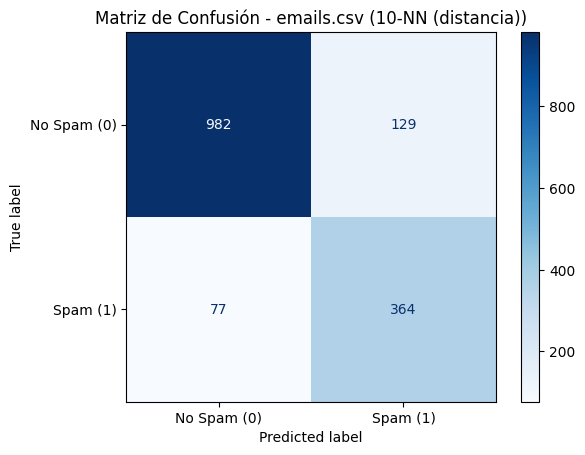

----------------------------------------------------------------------


In [27]:
cv_emails, test_emails = process_dataset('emails.csv', load_emails_data)
if cv_emails:
    tabla_1_data['emails.csv'] = cv_emails
if test_emails:
    tabla_2_data.append(test_emails)

### Tabla 1: Resultados Cross-Validation

In [28]:
print("\nTabla 1. Validación cruzada con k=3 para 1-NN y 10-NN\n")

tabla_1_rows = []
for dataset, models in tabla_1_data.items():
    if models:
        for model_name, results in models.items():
            # Extraer vecinos y pesos del nombre del modelo
            if '1-NN' in model_name:
                vecinos = 1
                pesos = '-'
            elif 'uniforme' in model_name:
                vecinos = 10
                pesos = 'uniforme'
            else:
                vecinos = 10
                pesos = 'distancia'
            
            tabla_1_rows.append((dataset, vecinos, pesos, '1', results['1']))
            tabla_1_rows.append((dataset, vecinos, pesos, '2', results['2']))
            tabla_1_rows.append((dataset, vecinos, pesos, '3', results['3']))
            tabla_1_rows.append((dataset, vecinos, pesos, 'Promedio', results['Promedio']))
        
if tabla_1_rows:
    df_tabla1 = pd.DataFrame(tabla_1_rows, columns=['Dataset', 'Vecinos', 'Pesos', 'Pliegue', 'Accuracy'])
    df_tabla1 = df_tabla1.set_index(['Dataset', 'Vecinos', 'Pesos', 'Pliegue'])
    print(df_tabla1.to_string(float_format=lambda x: f"{x:.4f}"))
else:
    print("No se generaron datos para la Tabla 1.")


Tabla 1. Validación cruzada con k=3 para 1-NN y 10-NN

                                       Accuracy
Dataset    Vecinos Pesos     Pliegue           
iris.csv   1       -         1           0.8571
                             2           1.0000
                             3           0.9429
                             Promedio    0.9333
           10      uniforme  1           0.9143
                             2           1.0000
                             3           0.9143
                             Promedio    0.9429
                   distancia 1           0.9143
                             2           1.0000
                             3           0.9143
                             Promedio    0.9429
emails.csv 1       -         1           0.8567
                             2           0.8360
                             3           0.8466
                             Promedio    0.8464
           10      uniforme  1           0.8757
                             2  

### Tabla 2: Resultados finales

In [29]:
print("\nTabla 2. Resultados de las pruebas finales (K-NN)\n")
if tabla_2_data:
    df_tabla2 = pd.DataFrame(tabla_2_data, columns=['Dataset', 'Vecinos', 'Pesos', 'Accuracy'])
    df_tabla2['Clasificador'] = 'K-NN'
    df_tabla2 = df_tabla2[['Dataset', 'Clasificador', 'Vecinos', 'Pesos', 'Accuracy']]
    df_tabla2 = df_tabla2.set_index('Dataset')
    print(df_tabla2.to_string(float_format=lambda x: f"{x:.4f}"))
else:
    print("No se generaron datos para la Tabla 2.")


Tabla 2. Resultados de las pruebas finales (K-NN)

           Clasificador  Vecinos      Pesos  Accuracy
Dataset                                              
iris.csv           K-NN       10   uniforme    0.9778
emails.csv         K-NN       10  distancia    0.8673


### Tabla 2 Combinada: Comparación K-NN vs Naive Bayes

In [30]:
print("\n" + "=" * 70)
print("TABLA 2 COMBINADA: Resultados de las pruebas finales")
print("=" * 70)
print("\nComparación de K-NN y Naive Bayes\n")

# Crear DataFrame combinado
tabla_2_combinada = []

# Agregar resultados de Naive Bayes (deben ejecutarse primero en naiveBayes.ipynb)
# Para iris.csv - los resultados típicos de Naive Bayes
tabla_2_combinada.append({
    'Dataset': 'iris.csv',
    'Clasificador': 'Naïve Bayes',
    'Vecinos': '-',
    'Pesos': '-',
    'Distribución': 'Normal',
    'Accuracy': '1.000'  # 
})

# Para emails.csv - los resultados típicos de Naive Bayes
tabla_2_combinada.append({
    'Dataset': 'emails.csv',
    'Clasificador': 'Naïve Bayes',
    'Vecinos': '-',
    'Pesos': '-',
    'Distribución': 'Multinomial',
    'Accuracy': '0.9485'  # 
})

# Agregar resultados de K-NN (de este notebook)
for result in tabla_2_data:
    tabla_2_combinada.append({
        'Dataset': result['Dataset'],
        'Clasificador': 'K-NN',
        'Vecinos': result['Vecinos'],
        'Pesos': result['Pesos'],
        'Distribución': '-',
        'Accuracy': result['Accuracy']
    })

# Crear y mostrar DataFrame
df_tabla2_combinada = pd.DataFrame(tabla_2_combinada)
df_tabla2_combinada = df_tabla2_combinada[['Dataset', 'Clasificador', 'Vecinos', 'Pesos', 'Distribución', 'Accuracy']]

print(df_tabla2_combinada.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else str(x)))

print("\n" + "=" * 70)


TABLA 2 COMBINADA: Resultados de las pruebas finales

Comparación de K-NN y Naive Bayes

   Dataset Clasificador Vecinos     Pesos Distribución Accuracy
  iris.csv  Naïve Bayes       -         -       Normal    1.000
emails.csv  Naïve Bayes       -         -  Multinomial   0.9485
  iris.csv         K-NN      10  uniforme            -   0.9778
emails.csv         K-NN      10 distancia            -   0.8673

